In [296]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

import seaborn as sns

from datetime import datetime

from scipy import stats
from scipy.stats import normaltest

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.statespace import sarimax

%matplotlib inline

In [297]:
df_orig = pd.read_csv('eps.csv')
#df = df[30000:100000]

In [298]:
def convertEpochToDate():
    df_orig['date'] = pd.to_datetime(df_orig['time'], unit='ms')

convertEpochToDate()

In [299]:
df_day.head()

,eps,date
0,787,2018-06-14 15:05:28.294
1,730,2018-06-14 15:06:28.294
2,818,2018-06-14 15:07:28.294
3,863,2018-06-14 15:08:28.295
4,715,2018-06-14 15:09:28.296


In [300]:
df_day = df_orig.resample('D', on='date')['eps'].mean()

In [301]:
df_day.head()

date
2018-06-14    581.781308
2018-06-15    490.330556
2018-06-16    570.115278
2018-06-17    538.845833
2018-06-18    488.555556
Freq: D, Name: eps, dtype: float64

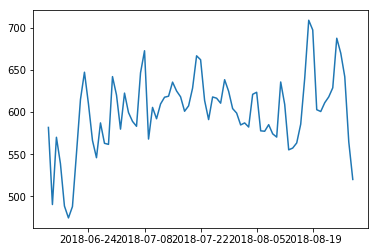

In [304]:
sns.lineplot(data=df_day)

In [305]:
def determineWeekDay():
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M")
    df['weekday'] = df['date'].dt.weekday

#determineWeekDay()
#sns.boxplot(x="weekday", y="eps", data=df)

In [306]:
def test_stationarity(timeseries, window = 1):
    rollMean = timeseries.rolling(window).mean()
    rollStd = timeseries.rolling(window).std()

    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, label = 'Original')
    mean = plt.plot(rollMean, label = 'Rolling Mean')
    std  = plt.plot(rollStd, label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')

    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    
    print(dfoutput)


In [313]:
#Window is for 24 hrs: 60*24
window_size = 30

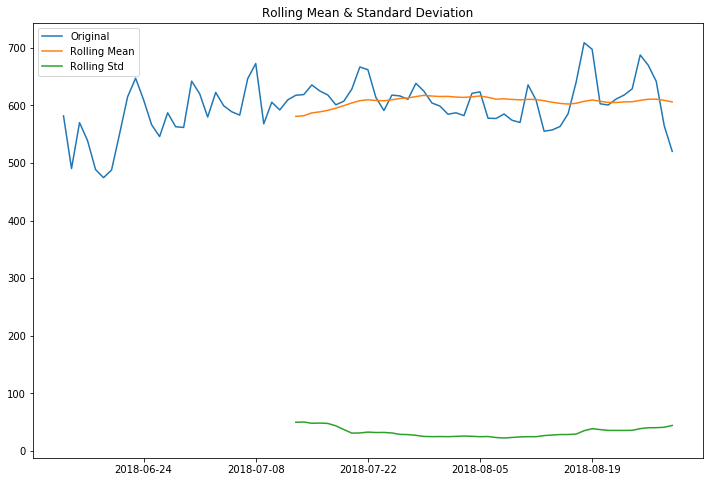

Results of Dickey-Fuller Test:
Test Statistic                 -3.896101
p-value                         0.002064
#Lags Used                      7.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [314]:
test_stationarity(df_day, window = window_size)

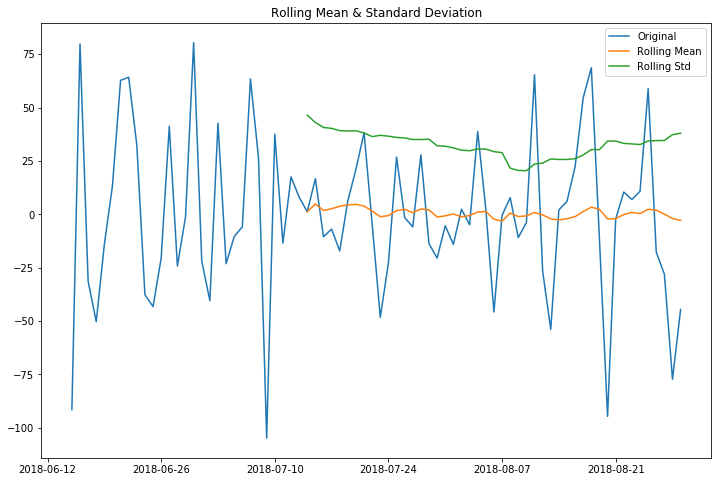

Results of Dickey-Fuller Test:
Test Statistic                -7.814012e+00
p-value                        6.947580e-12
#Lags Used                     5.000000e+00
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64


In [318]:
df_day_diff = df_day - df_day.shift(1)
df_day_diff = df_day_diff.dropna(inplace = False)
test_stationarity(df_day_diff, window = window_size)

In [320]:
def seasonalDecompose(timeSeries):
    seasonal_decompose_result = seasonal_decompose(timeSeries, freq = window_size)

    fig = plt.figure()
    fig = seasonal_decompose_result.plot()
    fig.set_size_inches(15, 12)

    return seasonal_decompose_result

<Figure size 432x288 with 0 Axes>

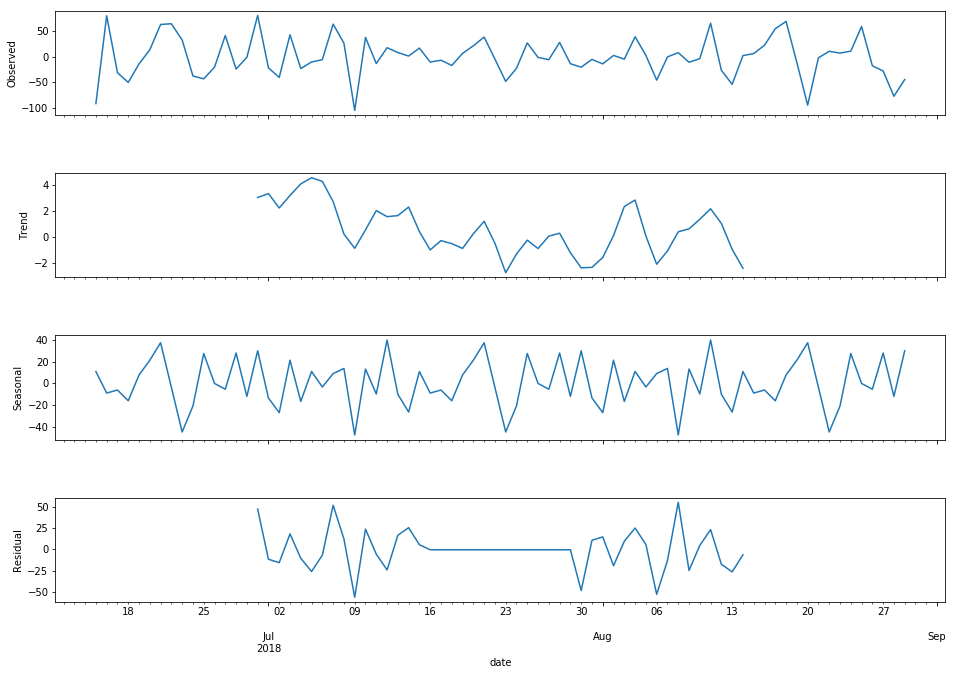

In [326]:
#decompose_result = seasonalDecompose(df_day)
decompose_result_diff = seasonalDecompose(df_day_diff)

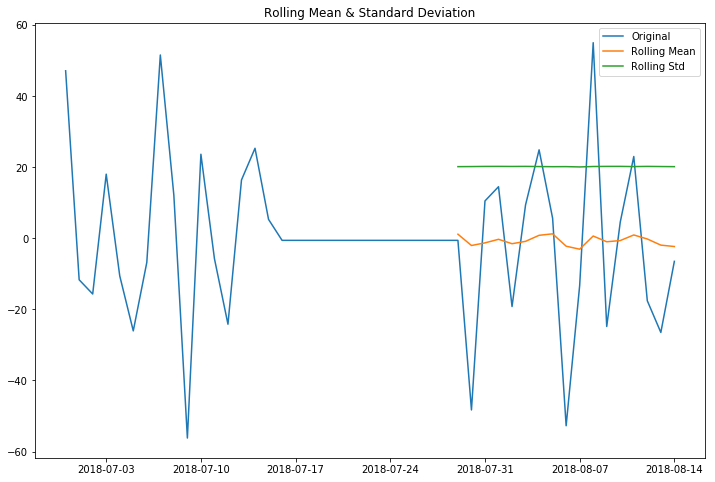

Results of Dickey-Fuller Test:
Test Statistic                 -2.725154
p-value                         0.069786
#Lags Used                      6.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


In [327]:
#ADF of residual
decompose_residual = decompose_result_diff.resid
decompose_residual.dropna(inplace=True)
test_stationarity(decompose_residual, window = window_size)

In [328]:
def plotAcfAndPacf(series, lag = 40):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, lags = lag, ax = ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags = lag, ax = ax2)

D:\Tools\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


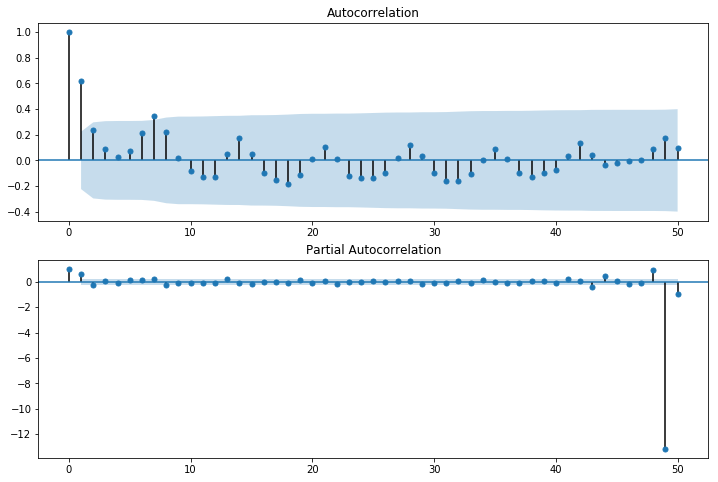

In [357]:
plotAcfAndPacf(df_day, lag = 50)
#plotAcfAndPacf(df_day_diff, lag = 50)

In [63]:
p = [4]
d = [1]
q = [2]
s = [0]

pdq = list(itertools.product(p, d, q))
PDQs = list(itertools.product(p, d, q, s))

In [65]:
def calculateAllPossibilities():
    for param in pdq:
        for seasonal_param in PDQs:
            print('SARIMA for {}x{}'.format(param, seasonal_param))
            sarima_results = sm.tsa.statespace.SARIMAX(
                df['eps'],
                order = param,
                #seasonal_order = seasonal_param,
                enforce_stationarity = False,
                enforce_invertibility = False).fit()

            print('Beginning to fit')
            #sarima_results = sarima_mod
            print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_param, sarima_results.aic))


#calculateAllPossibilities()

In [64]:
def plotResidualDistribution(sarima_result):
    residual = sarima_result.resid
    print(normaltest(residual))

    fig = plt.figure(figsize=(10,8))
    ax0 = fig.add_subplot(111)

    sns.distplot(residual ,fit = stats.norm, ax = ax0)

In [383]:
sarima_mod_result = sm.tsa.statespace.SARIMAX(df_day, 
                                              order=(6,0,1),
                                              #seasonal_order=(6, 0, 2, 1),
                                              trend='n',
                                              enforce_stationarity = False,
                                              enforce_invertibility = False).fit()

D:\Tools\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NormaltestResult(statistic=100.03529468320636, pvalue=1.8950111155936714e-22)
                           Statespace Model Results                           
Dep. Variable:                    eps   No. Observations:                   77
Model:               SARIMAX(6, 0, 1)   Log Likelihood                -340.698
Date:                Sat, 01 Sep 2018   AIC                            697.397
Time:                        19:03:02   BIC                            715.498
Sample:                    06-14-2018   HQIC                           704.595
                         - 08-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1977      0.315      3.802      0.000       0.580       1.815
ar.L2         -0.6880      0.346     -1.991      0.04

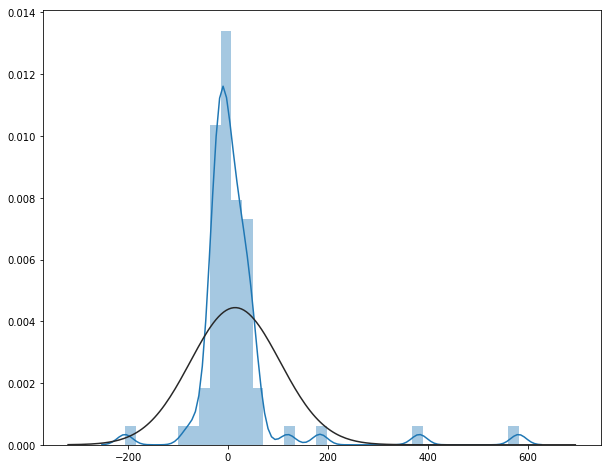

In [384]:
plotResidualDistribution(sarima_mod_result)
print(sarima_mod_result.summary())

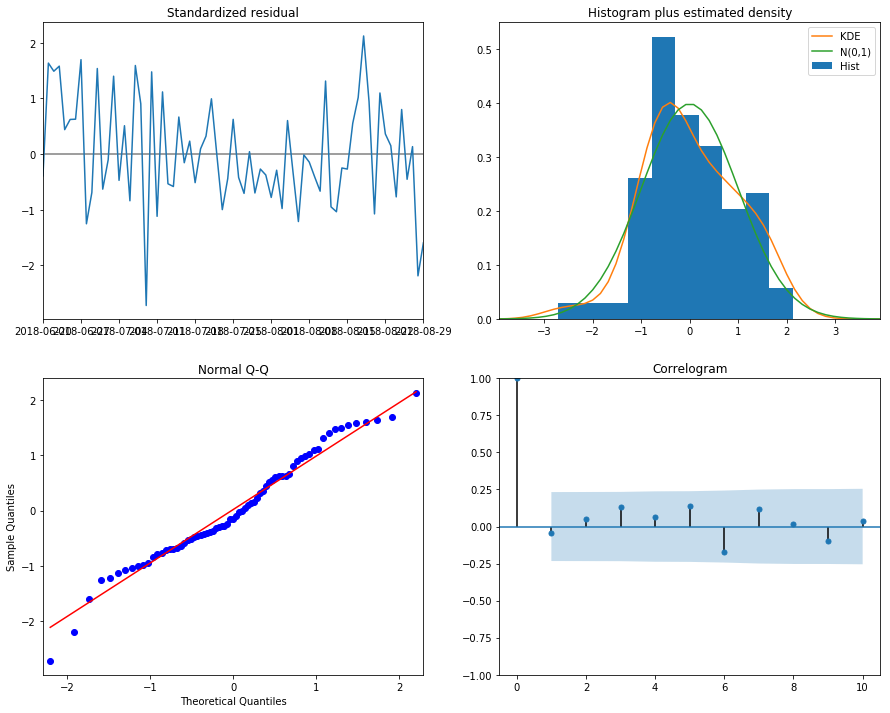

In [385]:
sarima_mod_result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [386]:
pred = sarima_mod_result.get_prediction(dynamic=False)
pred_ci = pred.conf_int()
pred.predicted_mean.head()

date
2018-06-14      0.000000
2018-06-15    696.819626
2018-06-16    187.066773
2018-06-17    537.424288
2018-06-18    304.445886
Freq: D, dtype: float64

In [387]:
df_day.head()

date
2018-06-14    581.781308
2018-06-15    490.330556
2018-06-16    570.115278
2018-06-17    538.845833
2018-06-18    488.555556
Freq: D, Name: eps, dtype: float64

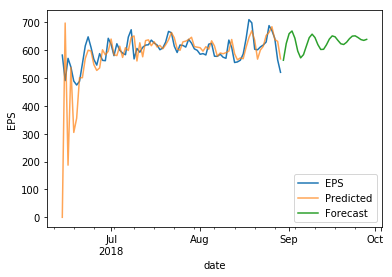

In [388]:
ax = df_day.plot(label='EPS')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7)
sarima_mod_result.get_forecast(30).predicted_mean.plot(ax=ax, label='Forecast')

#ax.set_xlabel('Time (years)')
ax.set_ylabel('EPS')
plt.legend()

plt.show()

In [391]:
sarima_mod_result.get_forecast(30).predicted_mean.to_csv('forecast.csv')

In [389]:
sarima_mod_result.get_forecast(30).predicted_mean

2018-08-30    563.437176
2018-08-31    623.562657
2018-09-01    658.620062
2018-09-02    668.232325
2018-09-03    642.456794
2018-09-04    596.258340
2018-09-05    571.845612
2018-09-06    583.376386
2018-09-07    614.043726
2018-09-08    644.180452
2018-09-09    656.886053
2018-09-10    644.655151
2018-09-11    619.568220
2018-09-12    601.993339
2018-09-13    602.570846
2018-09-14    618.698109
2018-09-15    639.119412
2018-09-16    650.669613
2018-09-17    647.374095
2018-09-18    634.361457
2018-09-19    622.403905
2018-09-20    619.801683
2018-09-21    627.776586
2018-09-22    640.566218
2018-09-23    649.879152
2018-09-24    650.835706
2018-09-25    644.782033
2018-09-26    637.428106
2018-09-27    634.534486
2018-09-28    638.204033
Freq: D, dtype: float64

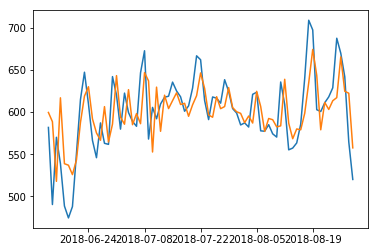

In [380]:
arima_model = ARIMA(df_day, order=(1,0,1))
arima_results = arima_model.fit(disp=-1)
plt.plot(df_day)
plt.plot(arima_results.fittedvalues)

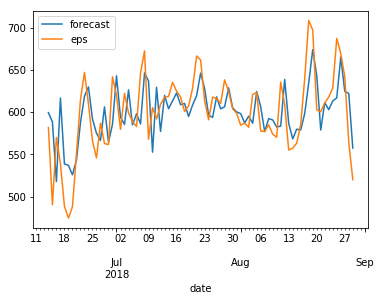

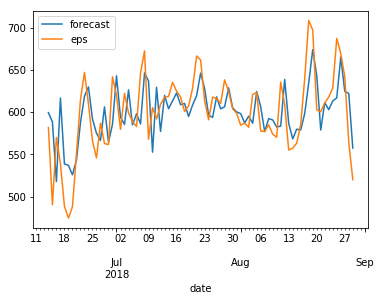

In [381]:
arima_results.plot_predict(dynamic=False)